## Dependencies

In [1]:
import json, warnings, shutil, glob
from jigsaw_utility_scripts import *
from scripts_step_lr_schedulers import *
from transformers import TFXLMRobertaModel, XLMRobertaConfig
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [2]:
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Load data

In [3]:
database_base_path = '/kaggle/input/jigsaw-data-split-roberta-128-ratio-2-high/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
valid_df = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv", 
                       usecols=['comment_text', 'toxic', 'lang'])

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print('Validation samples: %d' % len(valid_df))
display(valid_df.head())

base_data_path = 'fold_1/'
# Unzip files
!tar -xvf /kaggle/input/jigsaw-data-split-roberta-128-ratio-2-high/fold_1.tar.gz

Train samples: 207593


,comment_text,toxic,toxic_int,length,word_count,token_count,fold_1,fold_2,fold_3,fold_4,fold_5
0,Why is the headline and the first paragraphs n...,0.000000,0,881,144,205,train,train,train,validation,train
1,Democrats speaking of a moral compass when the...,0.806452,1,173,22,52,train,train,validation,train,train
2,It's not currently a flood. It's been a trickl...,0.000000,0,100,19,31,train,validation,train,train,train
3,::May I ask what interest you have in these is...,0.000000,0,51,10,14,train,train,validation,train,train
4,"Yup, you would think they were the majority. C...",0.000000,0,226,40,56,validation,train,train,train,train


Validation samples: 8000


,comment_text,lang,toxic
0,Este usuario ni siquiera llega al rango de ...,es,0
1,Il testo di questa voce pare esser scopiazzato...,it,0
2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


fold_1/
fold_1/x_train.npy
fold_1/x_valid.npy
fold_1/x_valid_tail.npy
fold_1/y_train_int.npy
fold_1/y_valid.npy
fold_1/y_valid_int.npy
fold_1/x_train_tail.npy
fold_1/y_train.npy


# Model parameters

In [4]:
base_path = '/kaggle/input/jigsaw-transformers/XLM-RoBERTa/'

config = {
  "MAX_LEN": 128,
  "BATCH_SIZE": 128,
  "EPOCHS": 4,
  "LEARNING_RATE": 1e-5, 
  "ES_PATIENCE": None,
  "base_model_path": base_path + 'tf-xlm-roberta-large-tf_model.h5',
  "config_path": base_path + 'xlm-roberta-large-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

## Learning rate schedule

Learning rate schedule: 1e-07 to 9.87e-06 to 9.71e-07


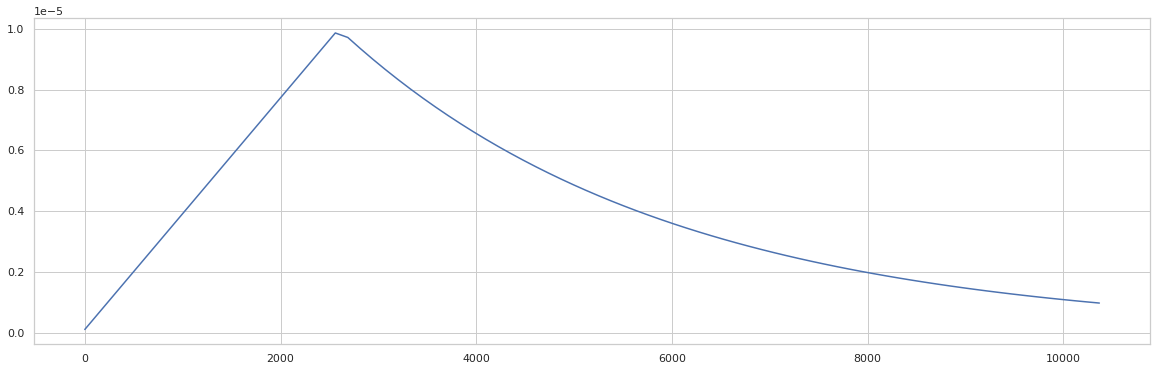

In [5]:
lr_min = 1e-7
lr_start = 1e-7
lr_max = config['LEARNING_RATE']
step_size = len(k_fold[k_fold['fold_1'] == 'train']) // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size * 2 # tail
hold_max_steps = 0
warmup_steps = step_size * 1 * 2 # tail
decay = .9997

rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
y = [exponential_schedule_with_warmup(tf.cast(x, tf.float32), warmup_steps, hold_max_steps, 
                                      lr_start, lr_max, lr_min, decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [6]:
module_config = XLMRobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFXLMRobertaModel.from_pretrained(config['base_model_path'], config=module_config)
    last_hidden_state, _ = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    cls_token = last_hidden_state[:, 0, :]
    
    output = layers.Dense(1, activation='sigmoid', name='output')(cls_token)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    
    return model

# Train

In [7]:
# Load data
x_train = np.load(base_data_path + 'x_train.npy')
y_train = np.load(base_data_path + 'y_train.npy').reshape(x_train.shape[1], 1).astype(np.float32)
x_valid_ml = np.load(database_base_path + 'x_valid.npy')
y_valid_ml = np.load(database_base_path + 'y_valid.npy').reshape(x_valid_ml.shape[1], 1).astype(np.float32)

#################### ADD TAIL ####################
x_train = np.hstack([x_train, np.load(base_data_path + 'x_train_tail.npy')])
y_train = np.vstack([y_train, y_train])

step_size = x_train.shape[1] // config['BATCH_SIZE']
valid_step_size = x_valid_ml.shape[1] // config['BATCH_SIZE']

# Build TF datasets
train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO, seed=SEED))
valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(x_valid_ml, y_valid_ml, config['BATCH_SIZE'], AUTO, repeated=True, seed=SEED))
train_data_iter = iter(train_dist_ds)
valid_data_iter = iter(valid_dist_ds)

# Step functions
@tf.function
def train_step(data_iter):
    def train_step_fn(x, y):
        with tf.GradientTape() as tape:
            probabilities = model(x, training=True)
            loss = loss_fn(y, probabilities)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        train_auc.update_state(y, probabilities)
        train_loss.update_state(loss)
    for _ in tf.range(step_size):
        strategy.experimental_run_v2(train_step_fn, next(data_iter))

@tf.function
def valid_step(data_iter):
    def valid_step_fn(x, y):
        probabilities = model(x, training=False)
        loss = loss_fn(y, probabilities)
        valid_auc.update_state(y, probabilities)
        valid_loss.update_state(loss)
    for _ in tf.range(valid_step_size):
        strategy.experimental_run_v2(valid_step_fn, next(data_iter))

# Train model
with strategy.scope():
    model = model_fn(config['MAX_LEN'])
    optimizer = optimizers.Adam(learning_rate=lambda: 
                                exponential_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                                 warmup_steps, hold_max_steps, lr_start, 
                                                                 lr_max, lr_min, decay))
    loss_fn = losses.binary_crossentropy
    train_auc = metrics.AUC()
    valid_auc = metrics.AUC()
    train_loss = metrics.Sum()
    valid_loss = metrics.Sum()

metrics_dict = {'loss': train_loss, 'auc': train_auc, 
                'val_loss': valid_loss, 'val_auc': valid_auc}

history = custom_fit(model, metrics_dict, train_step, valid_step, train_data_iter, valid_data_iter, 
                     step_size, valid_step_size, config['BATCH_SIZE'], config['EPOCHS'], 
                     config['ES_PATIENCE'], save_last=False)
# model.save_weights('model.h5')

# Make predictions
x_train = np.load(base_data_path + 'x_train.npy')
x_valid = np.load(base_data_path + 'x_valid.npy')
x_valid_ml_eval = np.load(database_base_path + 'x_valid.npy')

train_preds = model.predict(get_test_dataset(x_train, config['BATCH_SIZE'], AUTO))
valid_preds = model.predict(get_test_dataset(x_valid, config['BATCH_SIZE'], AUTO))
valid_ml_preds = model.predict(get_test_dataset(x_valid_ml_eval, config['BATCH_SIZE'], AUTO))

k_fold.loc[k_fold['fold_1'] == 'train', 'pred_1'] = np.round(train_preds)
k_fold.loc[k_fold['fold_1'] == 'validation', 'pred_1'] = np.round(valid_preds)
valid_df['pred_1'] = valid_ml_preds


# Fine-tune on validation set
x_train_ml_tail = x_valid_ml.copy()
y_train_ml_tail = y_valid_ml.copy()
#################### ADD TAIL ####################
x_train_ml_tail = np.hstack([x_train_ml_tail, np.load(database_base_path + 'x_valid_tail.npy')])
y_train_ml_tail = np.vstack([y_train_ml_tail, y_train_ml_tail])

valid_step_size_tail = x_train_ml_tail.shape[1] // config['BATCH_SIZE']

# Build TF datasets
train_ml_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_train_ml_tail, y_train_ml_tail, 
                                                                                 config['BATCH_SIZE'], AUTO, seed=SEED))
train_ml_data_iter = iter(train_ml_dist_ds)

history_ml = custom_fit(model, metrics_dict, train_step, valid_step, train_ml_data_iter, valid_data_iter, 
                        valid_step_size_tail, valid_step_size, config['BATCH_SIZE'], 1, 
                        config['ES_PATIENCE'], save_last=False)
model.save_weights('model_ml.h5')

# Make predictions
valid_ml_preds = model.predict(get_test_dataset(x_valid_ml_eval, config['BATCH_SIZE'], AUTO))
valid_df['pred_ml_1'] = valid_ml_preds

### Delete data dir
shutil.rmtree(base_data_path)

Train for 2594 steps, validate for 62 steps

EPOCH 1/4
time: 717.8s loss: 0.3409 auc: 0.9066 val_loss: 0.2409 val_auc: 0.9283

EPOCH 2/4
time: 527.2s loss: 0.2590 auc: 0.9455 val_loss: 0.2689 val_auc: 0.9219

EPOCH 3/4
time: 527.0s loss: 0.2384 auc: 0.9536 val_loss: 0.2827 val_auc: 0.9163

EPOCH 4/4
time: 527.1s loss: 0.2264 auc: 0.9578 val_loss: 0.3050 val_auc: 0.9125
Training finished
Train for 125 steps, validate for 62 steps

EPOCH 1/1
time: 629.4s loss: 1.6517 auc: 0.9915 val_loss: 0.0043 val_auc: 1.0000
Training finished


## Model loss graph

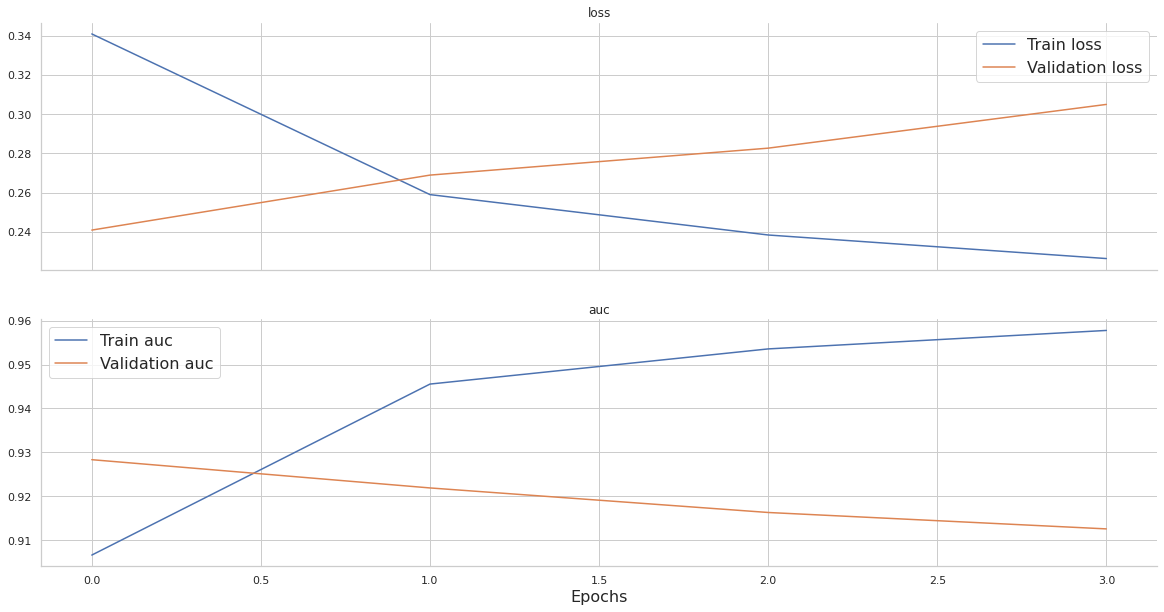

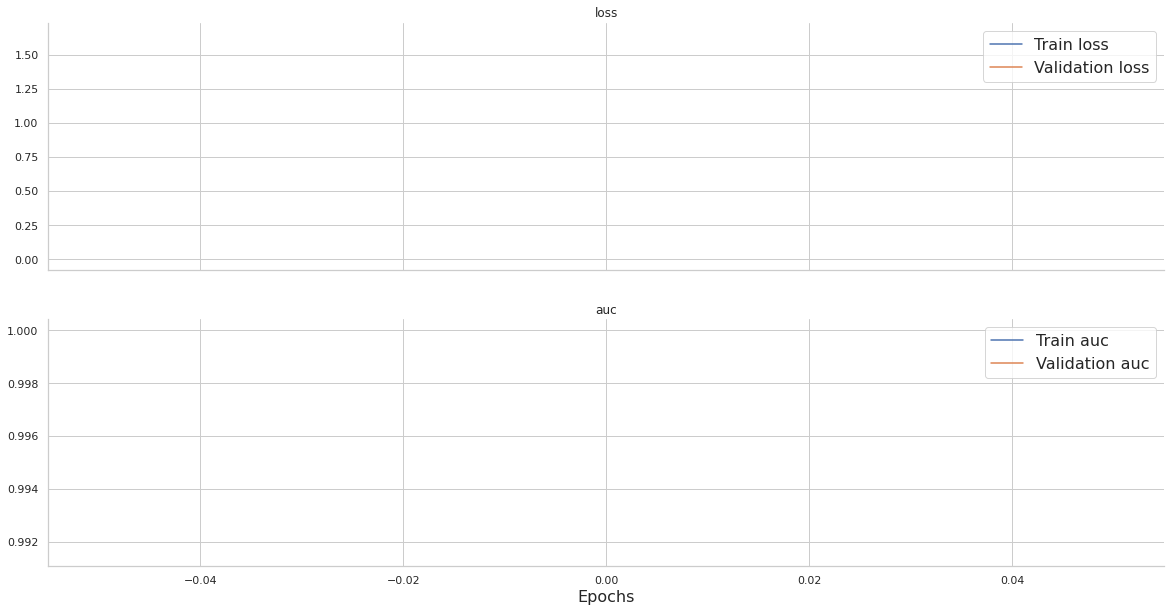

In [8]:
plot_metrics(history)
# ML fine-tunned preds
plot_metrics(history_ml)

# Model evaluation

In [9]:
display(evaluate_model(k_fold, 1, label_col='toxic_int').style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1
Metric,,,,,
ROC AUC,0.974795,0.945933,0.0288625,0.974795,0.945933
Accuracy,0.972591,0.945061,0.0275292,0.972591,0.945061
Precision,0.939291,0.893647,0.0456432,0.939291,0.893647
Recall,0.981449,0.948563,0.032886,0.981449,0.948563
F1-score,0.959907,0.920287,0.0396204,0.959907,0.920287
Support,55522,13881,41641,55522,13881


# Confusion matrix

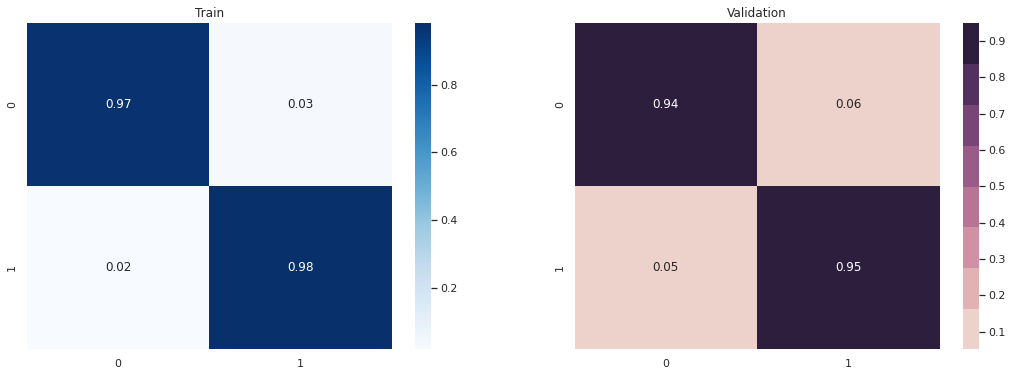

In [10]:
train_set = k_fold[k_fold['fold_1'] == 'train']
validation_set = k_fold[k_fold['fold_1'] == 'validation'] 
plot_confusion_matrix(train_set['toxic_int'], train_set['pred_1'], 
                      validation_set['toxic_int'], validation_set['pred_1'])

# Model evaluation by language

In [11]:
display(evaluate_model_lang(valid_df, 1).style.applymap(color_map))
# ML fine-tunned preds
display(evaluate_model_lang(valid_df, 1, pred_col='pred_ml').style.applymap(color_map))

,Mean,Fold_1
Lang / ROC AUC,,
Overall,0.917543,0.917543
es,0.89461,0.89461
it,0.885078,0.885078
tr,0.983643,0.983643


,Mean,Fold_1
Lang / ROC AUC,,
Overall,0.999992,0.999992
es,0.999977,0.999977
it,1,1
tr,1,1


# Visualize predictions

In [12]:
pd.set_option('max_colwidth', 120)
print('English validation set')
display(k_fold[['comment_text', 'toxic'] + [c for c in k_fold.columns if c.startswith('pred')]].head(10))

print('Multilingual validation set')
display(valid_df[['comment_text', 'toxic'] + [c for c in valid_df.columns if c.startswith('pred')]].head(10))

English validation set


,comment_text,toxic,pred_1
0,Why is the headline and the first paragraphs not spelling out clearly that the situation is one in which right wing ...,0.000000,0.0
1,"Democrats speaking of a moral compass when they support the immoral, vile, evil, foul-mouthed, lying, thieving, untr...",0.806452,1.0
2,It's not currently a flood. It's been a trickle for years. What we now see is the cumulative number.,0.000000,0.0
3,::May I ask what interest you have in these issues?,0.000000,0.0
4,"Yup, you would think they were the majority. Coincidentally, it's what Hillary needs to win. Duh!!!!!!! One day thos...",0.000000,0.0
5,MfD nomination of User:Inventor . Your opinions on the matter are welcome; please participate in the discussion by a...,0.000000,0.0
6,You mean that it is not some big conspiracy against the people (extremist few) of Broomfield?? *gasp*,0.000000,0.0
7,With a cent dollar surely BC softwood can compete in the US even with a duty. They managed to when the Canadian doll...,0.000000,0.0
8,"There has been no invasion of Ukraine, and there was no annexation of Ukrainian territory, or Crimea. Crimea's own d...",0.000000,0.0
9,I sure a significant minority of prisoners are there for drug related reasons. Reform our drug laws (say by legalizi...,0.000000,0.0


Multilingual validation set


,comment_text,toxic,pred_1,pred_ml_1
0,Este usuario ni siquiera llega al rango de hereje . Por lo tanto debería ser quemado en la barbacoa para purifi...,0,0.928364,2.944469e-04
1,"Il testo di questa voce pare esser scopiazzato direttamente da qui. Immagino possano esserci problemi di copyright, ...",0,0.000317,2.384186e-07
2,"Vale. Sólo expongo mi pasado. Todo tiempo pasado fue mejor, ni mucho menos, yo no quisiera retroceder 31 años a nive...",1,0.911337,9.999409e-01
3,Bu maddenin alt başlığı olarak uluslararası ilişkiler ile konuyu sürdürmek ile ilgili tereddütlerim var.Önerim siy...,0,0.000415,2.682209e-07
4,Belçika nın şehirlerinin yanında ilçe ve beldelerini yaparken sanırım Portekizi örnek alacaksın. Ben de uzak gelecek...,0,0.000336,0.000000e+00
5,"güzel, zaten kaynaklandırması zor subjektif kategoriler bunlar. bazı maddelerden çıkartmak, kiminden çıkartıp kimind...",0,0.002151,2.980232e-08
6,"No es mala idea. De hecho, yo estaba pensando descolgarme ya del reto mensual, pero esto vuelve a ilusionarme. El pr...",0,0.000353,0.000000e+00
7,"Kod hatalarını düzeltmişsiniz,elinize sağlık çok teşekkürler.Önceki sürümleri araştırdım.13 Haziran 2010 da Kullanıc...",0,0.000207,4.172325e-07
8,Levent Abi nasılsın? Hayat nasıl gidiyor? Umarım her şey istediğin gibidir. Bu arada Janet Jackson maddesi seçkin ma...,0,0.000588,1.192093e-07
9,"Creo que es importante que podamos reconocer a gente como Victor Manuel Vucetich , quien es originario de Tampico y ...",0,0.006885,5.632639e-06


# Test set predictions

In [13]:
x_test = np.load(database_base_path + 'x_test.npy')
test_preds = model.predict(get_test_dataset(x_test, config['BATCH_SIZE'], AUTO))

In [14]:
submission = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')
submission['toxic'] = test_preds
submission.to_csv('submission.csv', index=False)

display(submission.describe())
display(submission.head(10))

,id,toxic
count,63812.000000,6.381200e+04
mean,31905.500000,2.443561e-01
std,18421.082026,4.068404e-01
min,0.000000,0.000000e+00
25%,15952.750000,2.980232e-08
50%,31905.500000,6.645918e-06
75%,47858.250000,4.072302e-01
max,63811.000000,1.000000e+00


,id,toxic
0,0,0.000000e+00
1,1,1.788139e-07
2,2,3.552961e-02
3,3,1.460314e-06
4,4,2.384186e-07
5,5,5.924702e-05
6,6,0.000000e+00
7,7,2.384186e-07
8,8,7.297318e-01
9,9,9.133518e-04
